In [1]:
from astropy.table import QTable, Table, join, vstack
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy import constants as c
from astropy import units as u
import numpy as np
from glob import glob
from synphot import SpectralElement, units
from astropy.io import fits
import numpy as np
from glob import glob 
import aplpy
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube


plt.style.use('paper')

In [2]:
rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/' 
rootdir_bp = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/' 

t_uvis_f555w = Table.read('%s/HST_WFC3_UVIS1.F555W.dat' %rootdir_bp, format='ascii')
t_uvis_f657n = Table.read('%s/HST_WFC3_UVIS1.F657N.dat' %rootdir_bp, format='ascii')
t_uvis_f658n = Table.read('%s/HST_WFC3_UVIS1.F658N.dat' %rootdir_bp, format='ascii')
t_uvis_f814w = Table.read('%s/HST_WFC3_UVIS1.F814W.dat' %rootdir_bp, format='ascii')

t_acs_f555w = Table.read('%s/HST_ACS_WFC.F555W.dat' %rootdir_bp, format='ascii')
t_acs_f658n = Table.read('%s/HST_ACS_WFC.F658N.dat' %rootdir_bp, format='ascii')
t_acs_f814w = Table.read('%s/HST_ACS_WFC.F814W.dat' %rootdir_bp, format='ascii')

t_sample = Table.read('%s/sample_table/phangs_sample_table_v1p6.fits' %rootdir)

In [3]:
# Load the MUSE table
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/'
muscat_table_file = '%s/data_misc/Nebulae_catalogue_v4/Nebulae_catalogue_v4.fits' %root_dir
table_muse = QTable.read(muscat_table_file)

mask_flags = ~((table_muse['flag_edge']==1)|(table_muse['flag_star']==1))
table_muse = table_muse[mask_flags] 

In [4]:
def get_bandpassinfo(files):

    files.sort()

    bp = {}
    for file in files:

        print(file)

        area = 45238.93416 * units.AREA  # HST
        bp_ = SpectralElement.from_file(file)
        name = file.split('/')[-1].split('.dat')[0].replace('HST_', '').replace('.F', '_F')
        name = name.replace('WFC_', '')
        name = name.replace('WFC3_', '')
        name = name.replace('UVIS1', 'UVIS')

        bp[name] = {'equivwidth': bp_.equivwidth().value, 
                    'integrate': bp_.integrate().value, 
                    'rmswidth': bp_.rmswidth().value, 
                    'photbw': bp_.photbw().value, 
                    'fwhm': bp_.fwhm().value, 
                    'rectwidth': bp_.rectwidth().value, 
                    'pivot': bp_.pivot().value, 
                    'unit_response': bp_.unit_response(area).value}  
    
    return(bp)

files_bp = glob('%s*.dat' %rootdir_bp)
bp = get_bandpassinfo(files_bp)
bp.keys()

/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F550M.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_ACS_WFC.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F555W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F657N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F658N.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS1.F814W.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS2.F547M.dat
/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/hst_filters/HST_WFC3_UVIS2.F555W.dat
/Users/abarnes/Dropbox/work/Smal

dict_keys(['ACS_F550M', 'ACS_F555W', 'ACS_F658N', 'ACS_F814W', 'UVIS_F555W', 'UVIS_F657N', 'UVIS_F658N', 'UVIS_F814W', 'UVIS2_F547M', 'UVIS2_F555W', 'UVIS2_F657N', 'UVIS2_F658N', 'UVIS2_F673N', 'UVIS2_F814W'])

In [5]:
keys = list(bp.keys())
unit_response = [bp[key]['unit_response']/1e-19 for key in keys]
pivot = [bp[key]['pivot'] for key in keys]
rectwidth = [bp[key]['rectwidth'] for key in keys]

filter = [key.split('_')[0] for key in keys]
instr = [key.split('_')[-1] for key in keys]

t1 = Table.Column(filter, 'Filter')
t2 = Table.Column(instr, 'Instrument')
t3 = Table.Column(unit_response, 'photflam', unit=1e-19/(u.erg/u.s/u.cm**2/u.AA))
t4 = Table.Column(pivot, 'photplam', unit=u.AA)
t5 = Table.Column(rectwidth, 'photbw', unit=u.AA)

t_filters = Table([t1,t2,t3,t4,t5])
t_filters.write('%s/filter_table.fits'%rootdir_bp, overwrite=True)
t_filters.write('%s/filter_table.tex'%rootdir_bp, format='latex', formats={'photflam': '%0.3f', 'photplam': '%0.1f', 'photbw': '%0.1f'}, overwrite=True)

In [6]:
galaxies = ['ic5332', 'ngc0628', 'ngc5068', 'ngc4535', 'ngc4321',
            'ngc4303', 'ngc4254', 'ngc3627', 'ngc3351', 'ngc2835',
            'ngc1672', 'ngc1566', 'ngc1512', 'ngc1433', 'ngc1385',
            'ngc1365', 'ngc1300', 'ngc1087', 'ngc7496']

t_sample = vstack([t_sample[t_sample['name'] == name] for name in galaxies])
t_sample.sort('name')

t_sample['orient_vlsr_Ha_reshift'] = (((t_sample['orient_vlsr'].quantity/c.c.to('km/s')) * 6564.614) + 6564.614) * u.AA
t_sample.sort('orient_vlsr_Ha_reshift')
# t_sample['name', 'orient_vlsr','orient_vlsr_Ha_reshift']

In [15]:
galaxy = 'ngc2835s'

rootdir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_hstha/%s/' %galaxy
infile = '%s/muse/NGC2835-1.15asec.fits' %rootdir

hdu = fits.open(infile)[1]
cube = SpectralCube.read(hdu)

# spec = cube[:, 704, 335]
spec = cube[:, 450, 630]
spec_av = spec.value
spec_ax = spec.spectral_axis.value

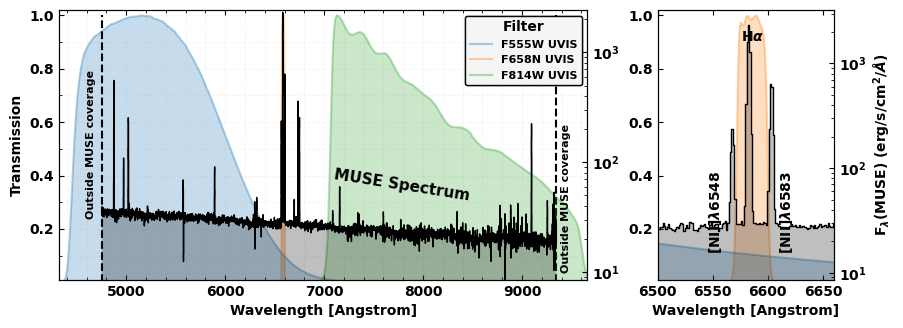

In [16]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(10,3.5), gridspec_kw={'width_ratios': [3, 1]})

ax2 = ax1.twinx()
ax4 = ax3.twinx()

for ax in [ax1, ax3]:

    ax.plot(t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max(), zorder=1, alpha=0.35, c='C1')
    ax.fill_between(t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max(), alpha=0.25, zorder=1, fc='C1')

    ax.plot(t_uvis_f555w['col1'], t_uvis_f555w['col2']/t_uvis_f555w['col2'].max(), zorder=2, alpha=0.35, c='C0')
    ax.fill_between(t_uvis_f555w['col1'], t_uvis_f555w['col2']/t_uvis_f555w['col2'].max(), alpha=0.25, zorder=2, fc='C0')

    ax.plot(t_uvis_f814w['col1'], t_uvis_f814w['col2']/t_uvis_f814w['col2'].max(), zorder=3, alpha=0.35, c='C2')
    ax.fill_between(t_uvis_f814w['col1'], t_uvis_f814w['col2']/t_uvis_f814w['col2'].max(), alpha=0.25, zorder=3, fc='C2')

    # ax.set_yscale('log')

    spec_min = min(spec_ax[~np.isnan(spec_av)])
    spec_max = max(spec_ax[~np.isnan(spec_av)])

    ax.vlines([spec_min, spec_max], 0, 1, ls='--', lw=1.5, color='k')

    ax.set_ylim([0.01, 1.02])

for ax in [ax2, ax4]:

    ax.plot(spec_ax, spec_av, ds='steps-mid', c='k', lw=1)
    ax.fill_between(spec_ax, spec_av, alpha=0.25, fc='k', step="mid", zorder=3)

    ax.set_yscale('log')

    ax.set_ylim([np.nanmin(spec_av), np.nanmax(spec_av)*1.05])

ax2.text(0.65, 0.35, 'MUSE Spectrum', transform=ax2.transAxes, fontsize=11, ha='center', va='center', rotation=-9, zorder=4, color='k')
ax2.text(0.06, 0.5, 'Outside MUSE coverage', transform=ax2.transAxes, fontsize=8, ha='center', va='center', rotation=90, zorder=4, color='k')
ax2.text(0.96, 0.3, 'Outside MUSE coverage', transform=ax2.transAxes, fontsize=8, ha='center', va='center', rotation=90, zorder=4, color='k')


ax4.text(0.54, 0.9, r'H$\alpha$', transform=ax4.transAxes, fontsize=10, ha='center', va='center', zorder=4, color='k')
ax4.text(0.33, 0.25, r'[NII]$\lambda6548$', transform=ax4.transAxes, fontsize=10, ha='center', va='center', zorder=4, color='k', rotation=90)
ax4.text(0.73, 0.25, r'[NII]$\lambda6583$', transform=ax4.transAxes, fontsize=10, ha='center', va='center', zorder=4, color='k', rotation=90)


ax1.set_xlim([4320, 9660])
ax3.set_xlim([6500, 6660])

ax4.set_ylim([np.nanmin(spec_av), np.nanmax(spec_av)*1.4])

ax1.set_xlabel('Wavelength [Angstrom]')
ax3.set_xlabel('Wavelength [Angstrom]')
ax1.set_ylabel('Transmission')

ax1.grid(':', alpha=0.2, which='both')

lines = ax1.get_lines()
legend1 = ax1.legend([lines[i] for i in [1,0, 2]], ["F555W UVIS", "F658N UVIS", "F814W UVIS"], 
                    fontsize=8, loc='upper right', title='Filter',
                    facecolor='whitesmoke', framealpha=0.95, edgecolor='k')
ax1.add_artist(legend1)

ax4.set_ylabel('F$_\lambda$(MUSE) (erg/s/cm$^2$/$\AA$)')

ax1.xaxis.set_minor_locator(MultipleLocator(200))
ax1.xaxis.set_major_locator(MultipleLocator(1000))

ax1.yaxis.set_minor_locator(MultipleLocator(0.1))

# fig.savefig('./figs/ngc2835s_filters_spec.pdf', dpi=300, bbox_inches='tight', transparent=False)

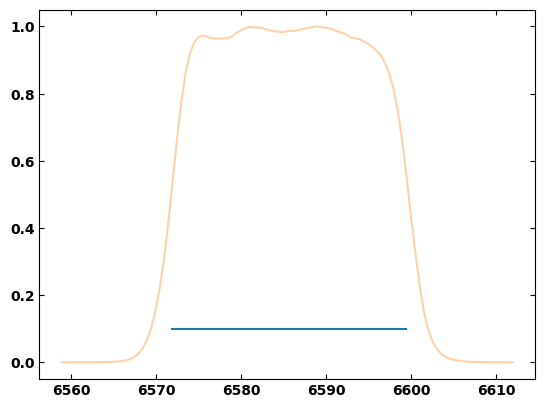

In [21]:
wave, trans = t_uvis_f658n['col1'], t_uvis_f658n['col2']/t_uvis_f658n['col2'].max()
centre = 6585.6242525638845
width = 27.53582335339542

plt.plot(wave, trans, zorder=1, alpha=0.35, c='C1')
plt.plot([centre-width/2, centre+width/2],[0.1,0.1])